<a href="https://colab.research.google.com/github/shella688/INT2-GROUP12/blob/main/vgg19_hand_coded.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import scipy.io
import numpy as np 

import torch
import torchvision # to load datasets 
import torchvision.transforms as transforms
import torch.nn as nn # basic building blocks for neural networks
import torch.nn.functional as F # convolution functions
import torch.optim as optim  # optimiser

In [20]:
net_layout = {"net": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        256,
        256,
        "M",
        512,
        512,
        512,
        512,
        "M",
        512,
        512,
        512,
        512,
        "M",
    ]}


# Each number is the out-channels for that layer
# M is a max pooling layer
# this dictionary will help us make our network later

In [21]:
class Net(nn.Module):
    def __init__(
        self,
        architecture,
        in_channels=3, 
        in_height=224, 
        in_width=224,  
        num_hidden=4096,
        num_classes=1000
    ):
        super(Net, self).__init__()
        self.in_channels = in_channels
        self.in_width = in_width
        self.in_height = in_height
        self.num_hidden = num_hidden
        self.num_classes = num_classes
        self.convs = self.init_convs(architecture)
        self.fcs = self.init_fcs(architecture)
        
    def forward(self, x):
        x = self.convs(x)
        x = x.reshape(x.size(0), -1)
        x = self.fcs(x)
        return x
    
    def init_fcs(self, architecture):
        pool_count = architecture.count("M")
        factor = (2 ** pool_count)
        if (self.in_height % factor) + (self.in_width % factor) != 0:
            raise ValueError(
                f"`in_height` and `in_width` must be multiples of {factor}"
            )
        out_height = self.in_height // factor
        out_width = self.in_width // factor
        last_out_channels = next(
            x for x in architecture[::-1] if type(x) == int
        )
        return nn.Sequential(
            nn.Linear(
                last_out_channels * out_height * out_width, 
                self.num_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(self.num_hidden, self.num_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(self.num_hidden, self.num_classes)
        )
    
    def init_convs(self, architecture):
        layers = []
        in_channels = self.in_channels
        
        for x in architecture:
            if type(x) == int:
                out_channels = x
                layers.extend(
                    [
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=out_channels,
                            kernel_size=(3, 3),
                            stride=(1, 1),
                            padding=(1, 1),
                        ),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU(),
                    ]
                )
                in_channels = x
            else:
                layers.append(
                    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
                )

        return nn.Sequential(*layers)
        


In [25]:
ourNetwork = Net(
    in_channels=3, 
    in_height=224, 
    in_width=224, 
    architecture=net_layout["net"]
)


In [26]:
print(ourNetwork)

Net(
  (convs): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1

In [27]:
# python image library has range [0,1]
# we want them transformed to tensors of normalised range [-1,1]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224, antialias=True),
    transforms.RandomCrop(224),
    # to change size: change both resize and randomcrop to be the same
    # (randomcrop to ensure image is square)
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

num_workers = 2

# load training data
flowertrainset = torchvision.datasets.Flowers102(root="./flowers", split="train",
                                           download=True, transform=transform)
flowertrainloader = torch.utils.data.DataLoader(flowertrainset,
                                     shuffle=True, num_workers=num_workers)

# load test data
flowertestset = torchvision.datasets.Flowers102(root="./flowers", split="test",
                                          download=True, transform=transform)
flowertestloader = torch.utils.data.DataLoader(flowertestset,
                                         shuffle=False, num_workers=num_workers)


flowervalset = torchvision.datasets.Flowers102("./flowers", split="val",
                                                       download=True, transform=transform)
flowervalloader = torch.utils.data.DataLoader(flowervalset,
                                              shuffle=True, num_workers=num_workers)



In [28]:
allLabels = scipy.io.loadmat("/content/flowers/flowers-102/imagelabels.mat")

flowerlabels = allLabels['labels']

flowerClasses = np.unique(flowerlabels)
# a list of every unique flower number

In [29]:
lossFunc = nn.CrossEntropyLoss()
# CEL combines log softmax and negative log-likelihood
# softmax - scales num to probabilites that add to 1
# log softmax - applies log transformation to softmax probs
# NL-L - calculates loss based on function range 
#      - small softmax value == large (even infinite) loss
#      - hight softmax value == smaller loss

SGD = optim.SGD(ourNetwork.parameters(), lr=0.001, momentum=0.9)
# SGC == Stochastic Gradient Descent

adam = optim.Adam(ourNetwork.parameters(), lr=0.005)
# Adam's optimiser

optimiser = adam

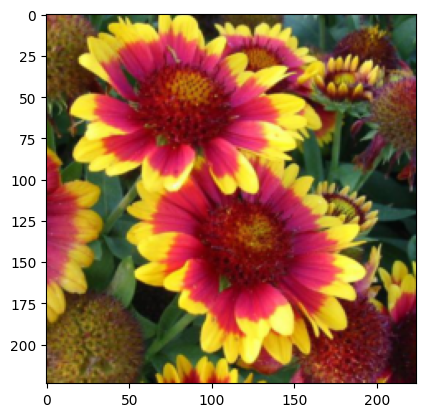

100


In [30]:
# visualise some images

def imshow(img):
  img = img / 2 + 0.5  # un-normalise 
  npimg = img.numpy()  # convert to numpy object 
  #print(npimg)
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show() 

# get random training images 
dataiter = iter(flowertrainloader)
images, labels = dataiter.__next__()


imshow(torchvision.utils.make_grid(images))

# print image class
print(' '.join('%s' % flowerClasses[labels[j]] for j in range(1)))

In [31]:
# test network on one test data

def oneTest():

  dataiter = iter(flowertestloader)
  images, labels = dataiter.__next__()

  # print test images 
  imshow(torchvision.utils.make_grid(images))
  print("Actual labels: ", ' '.join('%s' % 
                                            flowerClasses[labels[j]]
                                            for j in range(1)))

  outputs = ourNetwork(images)

  _, predicted = torch.max(outputs, dim=1)
  # max value of all elements in output tensor
  # dim is axis to find max value, in this case rows

  print("I predict it is: ", ' '.join('%s' % 
                                            flowerClasses[predicted[j]]
                                            for j in range(1)))


# Run trained model on test data

In [35]:
from torch.utils.data import dataloader
# now test on images in testing

def runTest():
  correct = 0
  total = 0 

  with torch.no_grad():
    for data in flowertestloader:
      images, labels = data 
      outputs = ourNetwork(images) 
      _, predicted = torch.max(outputs.data, 1) 
      total += labels.size(0)

      if total % 500 == 0:
        imshow(torchvision.utils.make_grid(images))
        print("Actual labels: ", ' '.join('%s' % 
                                          flowerClasses[labels[j]]
                                          for j in range(1)))
        print("I predict they are: ", ' '.join('%s' % 
                                          flowerClasses[predicted[j]]
                                          for j in range(1)))



      correct += (predicted == labels).sum().item()


  print('Accuracy of the network on the testing images: ', 100 * correct / total)

# Run trained model on validation data

In [36]:
from torch.utils.data import dataloader
# now test on images in validation

def runVal():

  correct = 0
  total = 0 

  with torch.no_grad():
    for data in flowervalloader:
      images, labels = data 
      outputs = ourNetwork(images) 
      _, predicted = torch.max(outputs.data, 1) 
      total += labels.size(0)

      if total % 500 == 0:
        imshow(torchvision.utils.make_grid(images))
        print("Actual labels: ", ' '.join('%s' % 
                                          flowerClasses[labels[j]]
                                          for j in range(1)))
        print("I predict they are: ", ' '.join('%s' % 
                                          flowerClasses[predicted[j]]
                                          for j in range(1)))



      correct += (predicted == labels).sum().item()


  print('Accuracy of the network on the validation images: ', 100 * correct / total)

# Run


[1,     1] loss: 0.900


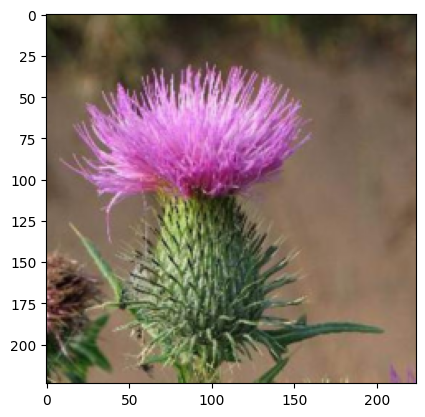

Actual labels:  14
I predict they are:  68


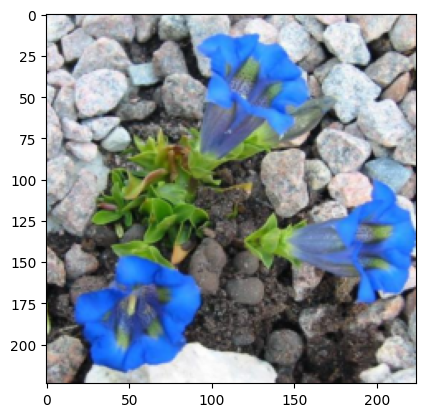

Actual labels:  28
I predict they are:  68


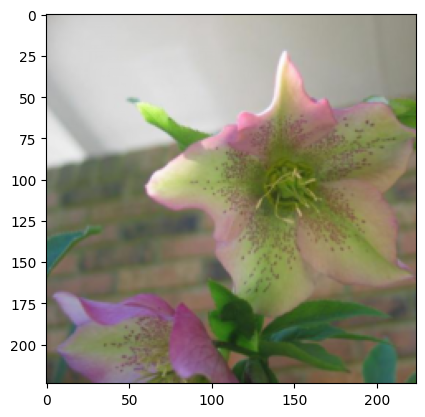

Actual labels:  40
I predict they are:  68


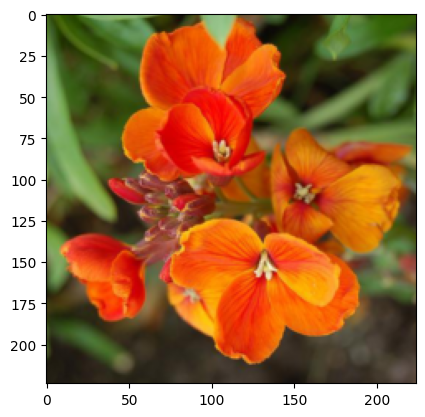

Actual labels:  46
I predict they are:  68


In [ ]:
# train network
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

loss_values = []

for epoch in range(1):
  # epoch = one pass over entire training set
  # too many can lead to overfitting, too few not enough training

  running_loss = 0.0 

  for i, data in enumerate(flowertrainloader, 0):
    # enumerate over training batches

    # get inputs
    # data is list of [input, label]
    inputs, labels = data 
    #print(inputs, labels)

    # zero gradients to prevent interferenec from past batch 
    optimiser.zero_grad()

    # frward, backward, + optimise 
    outputs = ourNetwork(inputs)
    #print(outputs.shape)

    loss = lossFunc(outputs, labels)
    loss.backward() 
    optimiser.step() 

    # print stats 
    running_loss += loss.item()
    loss_values.append(loss.item())
    # extract loss value as python float

    if i % 40 == 0:
      # print every 1000 ish mini-batches
      # means we don't need to calculate gradient of entire dataset
      print('[%d, %5d] loss: %.3f' %
          (epoch + 1, i + 1, running_loss / 2000))
      running_loss = 0.0

      runTest()
      runVal()

# stop timing 
end.record() 

# wait for everything to finish 
torch.cuda.synchronize() 
print("DONE")
milliseconds = start.elapsed_time(end)
seconds = milliseconds / 1000
minutes = seconds / 60
print(minutes)